In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name



# # Even transform in advance, the performance is still not good.
# # read in dataset
# dir = '../data/real/diag/Xichen/'

# counts_rnas = []
# counts_atacs = []
# counts_proteins = []
# for batch in [1, 2]:
#     try:
#         counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
#         counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

#     except:
#         counts_atac = None
        
#     try:
#         counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
#         counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
#     except:
#         counts_rna = None
    
#     # preprocess the count matrix
#     counts_rnas.append(counts_rna)
#     counts_atacs.append(counts_atac)


# counts_rnas[1] = counts_atacs[1] @ A.T
# counts = {"rna":counts_rnas}

# interacts = None

# # obtain the feature name
# genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
# regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

# counts["feats_name"] = {"rna": genes}
# counts["feats_name"] = feats_name



In [6]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
Ns = [8] * 2
K = 8
N_feat = Ns[0]
interval = 100
T = 10000
lr = 1e-2

In [7]:
# didn't use the interaction matrix
model1 = model.cfrm_new(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -110.9967
	 loss 1: 89.00313
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: -111.0564
	 loss 1: 88.94338
	 loss 2: 0.00000
	 loss 3: -199.99983
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: -113.3234
	 loss 1: 86.67168
	 loss 2: 0.00000
	 loss 3: -199.99506
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: -116.0104
	 loss 1: 83.98897
	 loss 2: 0.00000
	 loss 3: -199.99940
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: -116.4484
	 loss 1: 83.55125
	 loss 2: 0.00000
	 loss 3: -199.99962
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: -116.6535
	 loss 1: 83.34611
	 loss 2: 0.00000
	 loss 3: -199.99959
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: -116.7825
	 loss 1: 83.21708
	 loss 2: 0.00000
	 loss 3: -199.99960
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: -117.0574
	 loss

In [102]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [103]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.8, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

### Ground truth labeling

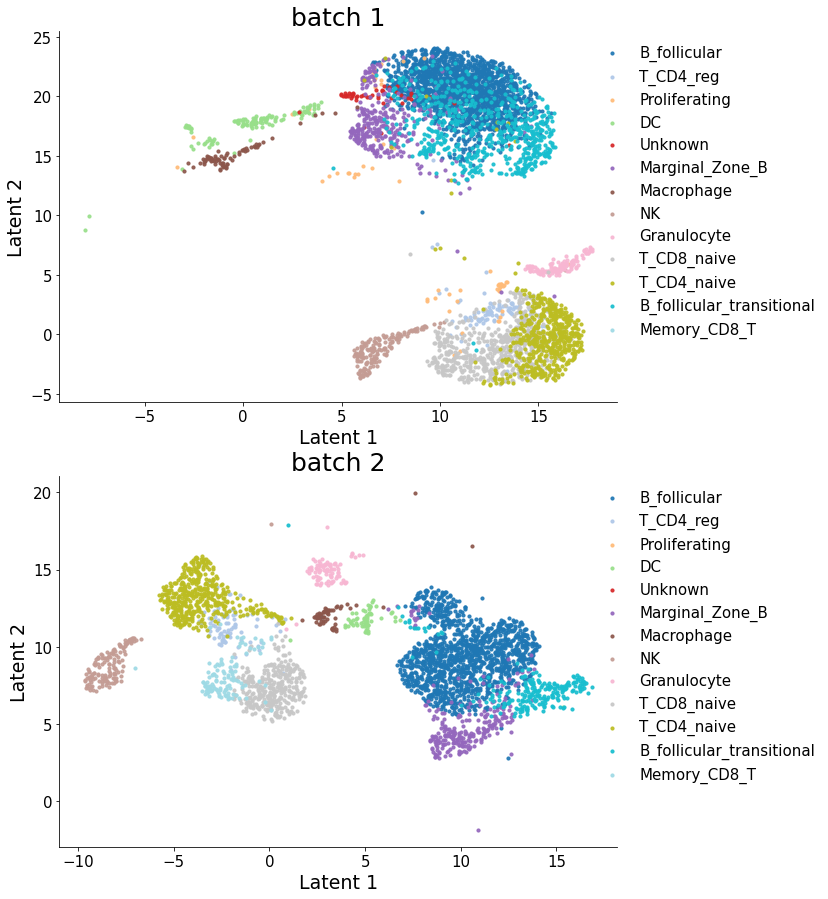

In [104]:
# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")


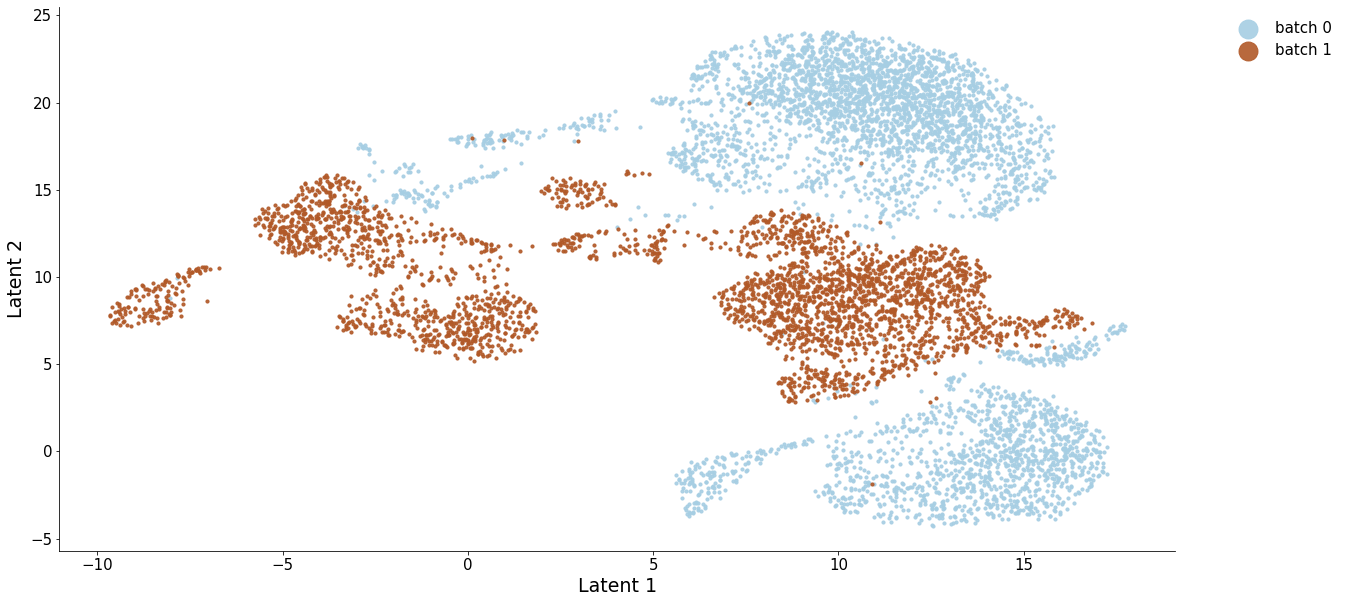

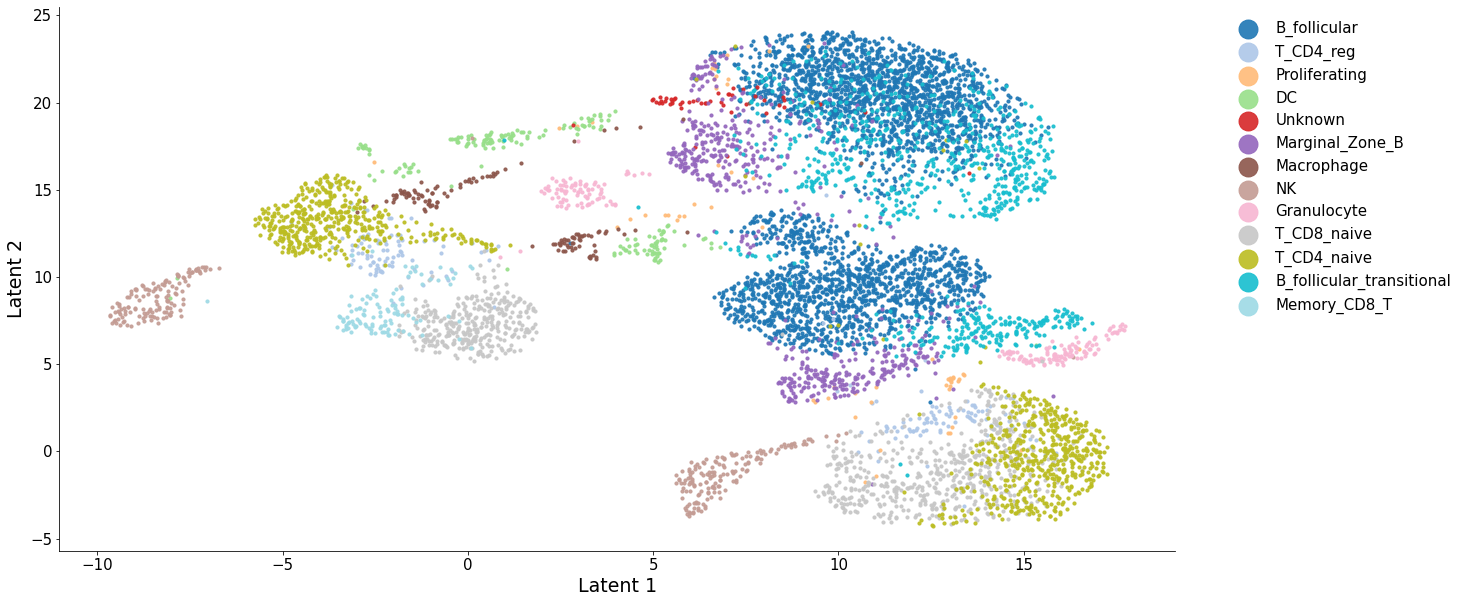

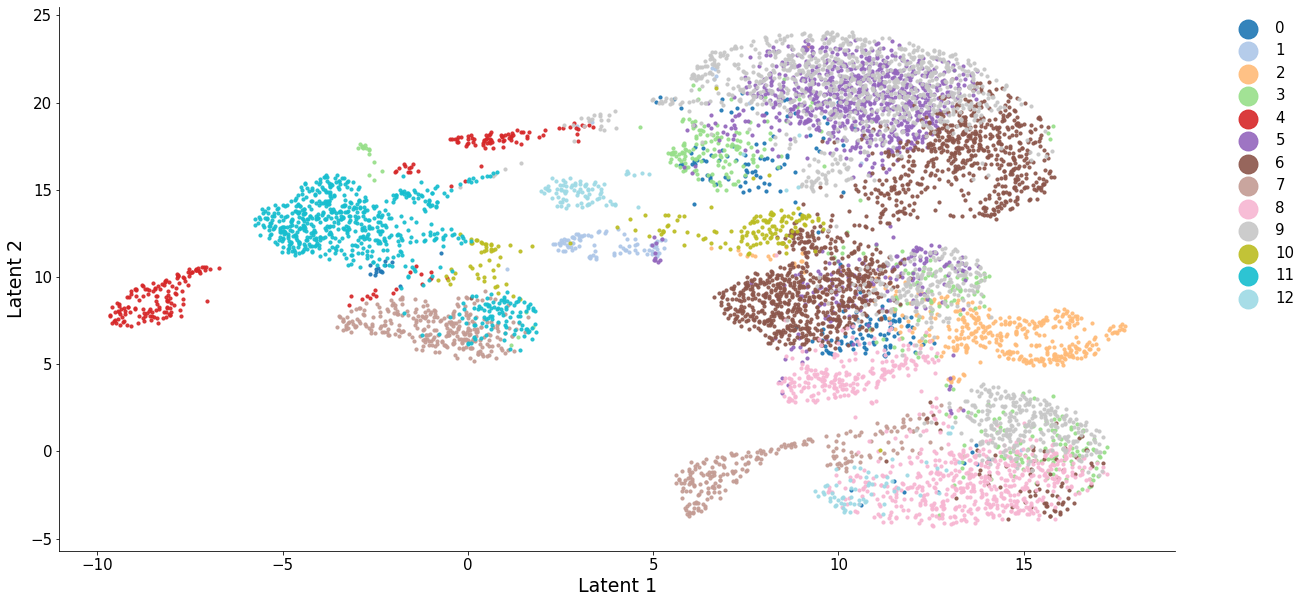

In [105]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


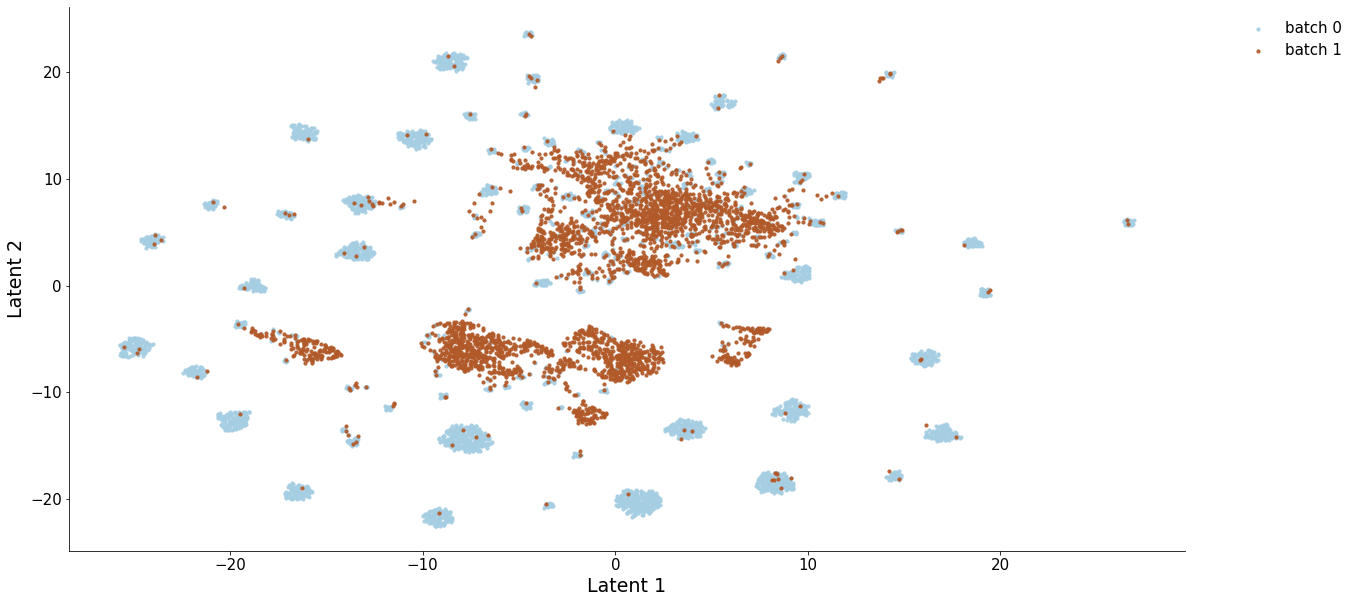

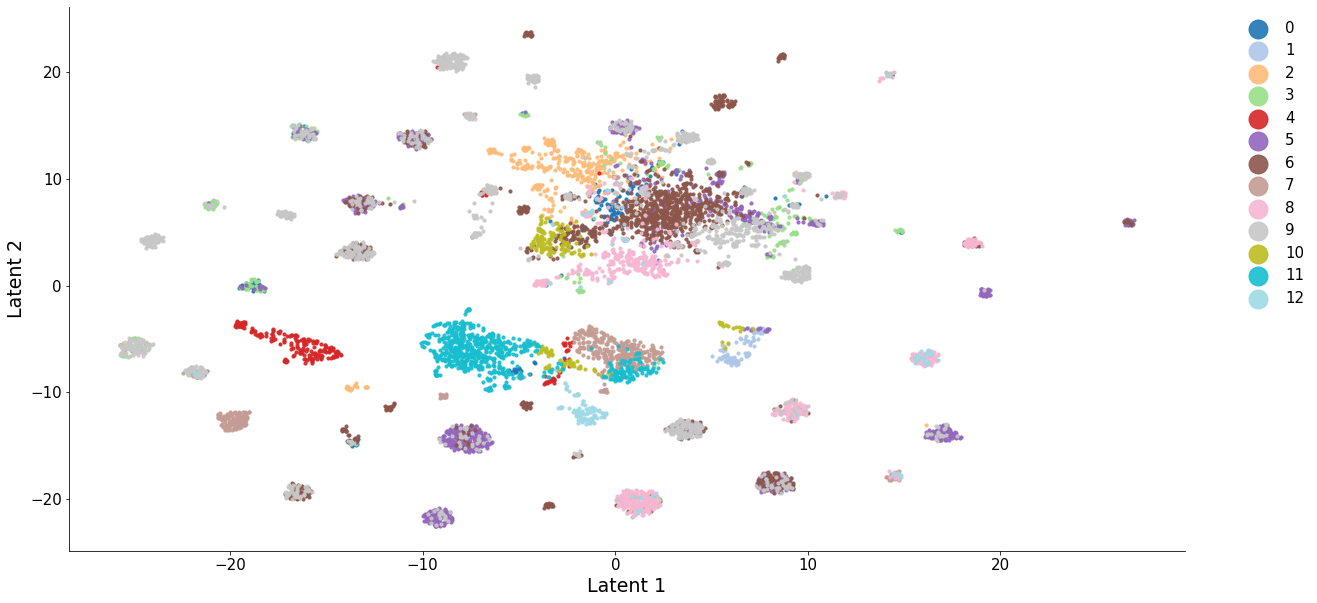

In [106]:
# scDART flavor

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 1, reference = 1, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


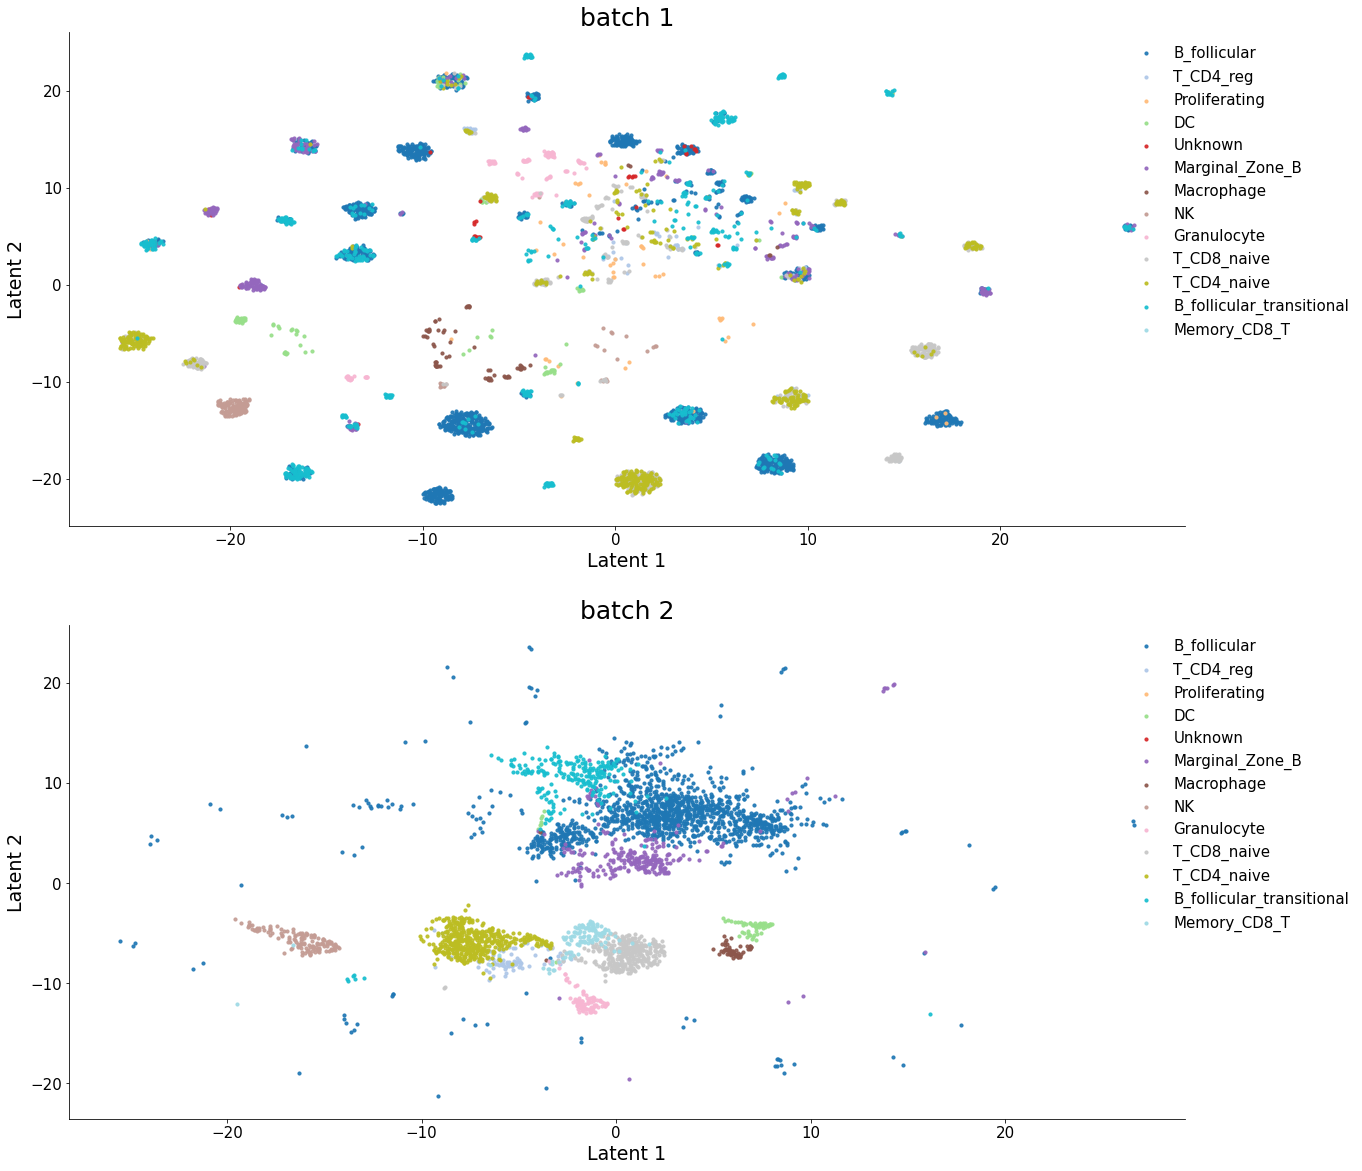

In [107]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (20,20), axis_label = "Latent")